In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
import itertools
from pygem_eb.processing.plotting_fxns import *
from objectives import *
data_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Summer MAE = 0.414   Winter MAE = 0.223'}, ylabel='Seasonal mass balance (m w.e.)'>)

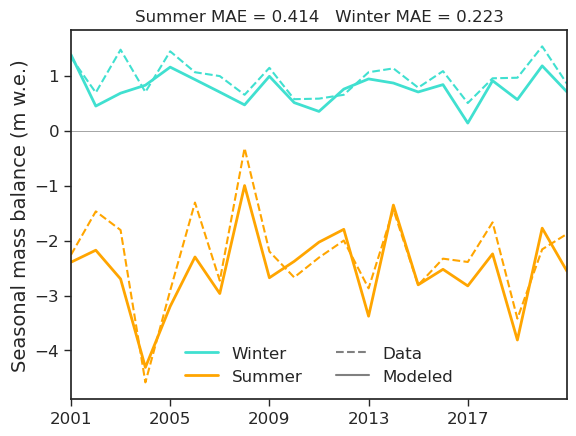

In [72]:
# PLOT A SINGLE RUN
path_out = '/home/claire/research/Output/calibration/09_23/'
kw = 1
k_snow = 'Douville'
a_ice = 0.6
site = 'B'
fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
ds,startdate,enddate = getds(path_out+fn)
seasonal_mass_balance(data_fp,ds,site,plot=True)

In [67]:
path_out = '/home/claire/research/Output/calibration/09_23/'
plot_site = 'AB'
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'a_ice':aa,'kw':ww,'k_snow':kk} # 

winter_result = np.ones((4,len(aa),len(ww),len(kk))) # 
summer_result = np.ones((4,len(aa),len(ww),len(kk)))
params = {'a_ice':[],'kw':[],'k_snow':[]} # 

for i,a_ice in enumerate(aa):
    for j,kw in enumerate(ww):
        for k,k_snow in enumerate(kk):
            params['a_ice'].append(a_ice)
            params['kw'].append(kw)
            params['k_snow'].append(k_snow)
            for s,site in enumerate(['AB','B','D']):
                # kw = 0.5 if site == 'D' else 1
                fn = f'kw{kw}_ksnow{k_snow}_aice{a_ice}_site{site}_0.nc'
                try:
                    ds,startdate,enddate = getds(path_out+fn)
                    winter,summer = seasonal_mass_balance(data_fp,ds,site=site,method='MAE')
                except:
                    winter,summer = (np.nan,np.nan)
                    print(fn+' does not exist')
                winter_result[s,i,j,k] = winter
                summer_result[s,i,j,k] = summer
            site_avg_summer = np.mean(summer_result[:,i,j,k])
            site_avg_winter = np.mean(winter_result[:,i,j,k])
            summer_result[3,i,j,k] = site_avg_summer
            winter_result[3,i,j,k] = site_avg_winter
print('When considering ALL parameters:')
for site in ['mean','D']:
    idx = np.where(np.array(['AB','B','D','mean']) == site)[0]
    best_winter = np.argmin(summer_result[idx].flatten())
    best_summer = np.argmin(winter_result[idx].flatten())

    winter_label = ''
    summer_label = ''
    for param in list(params.keys()):
        winter_label += param + ': ' + str(params[param][best_winter])+' '
        summer_label += param + ': ' + str(params[param][best_summer])+' '
    if site == 'mean':
        print(f'Best winter run was '+winter_label)
        print(f'Best summer run was '+summer_label)
    else:
        print(f'Best winter run for site {site} was {winter_label}')
        print(f'Best summer run for site {site} was {summer_label}')

When considering ALL parameters:
Best winter run was a_ice: 0.4 kw: 0.75 k_snow: Douville 
Best summer run was a_ice: 0.4 kw: 0.75 k_snow: Sturm 
Best winter run for site D was a_ice: 0.4 kw: 0.5 k_snow: Sturm 
Best summer run for site D was a_ice: 0.4 kw: 0.75 k_snow: Sturm 


In [65]:
# summer_result_ALL,winter_result_ALL = (summer_result.copy(),winter_result.copy())
# summer_result_NOKW,winter_result_NOKW = (summer_result.copy(),winter_result.copy())

In [60]:
def grid_plot(params_dict,summer_result,winter_result):
    """
    Parameters
    ----------
    params_dict : dict
        dict formatted as 'param_name':[option_1,option_2,...]
    result_summer and reuslt_winter : np.array
        should be size (N1xN2x...Nn) where:
            n is the number of param sets
            N is the number of options in each set
    """
    # Parse parameters
    param_names = list(params_dict.keys())
    combos = list(itertools.combinations(param_names,2))
    n_combos = len(combos)
    mid_idx = n_combos / 2
    if mid_idx % 1 != 0:
        mid_idx = int(mid_idx)

    # Create plot
    fig = plt.figure(figsize=(3*n_combos, 5))
    ratios = np.append(np.array([1]*n_combos).flatten(),0.3)
    gs = fig.add_gridspec(2,n_combos+1, wspace=1,hspace=0.5, width_ratios=ratios)

    # Normalize RMSE values across all three plots for shared colorbar
    all_summer = summer_result[~np.isnan(summer_result)].flatten()
    all_winter = winter_result[~np.isnan(winter_result)].flatten()
    norm_summer = plt.Normalize(vmin=np.min(all_summer), vmax=np.max(all_summer))
    norm_winter = plt.Normalize(vmin=np.min(all_winter), vmax=np.max(all_winter))
    cmap = 'viridis_r'
    ylabels = False
    xlabels = False

    # Create the scatter plots
    for j,pair in enumerate(combos):
        param_1 = params_dict[pair[0]]
        param_2 = params_dict[pair[1]]
        if type(param_1[0]) == str:
            xlabels = param_1
            param_1 = np.arange(len(param_1))
        if type(param_2[0]) == str:
            ylabels = np.flip(param_2)
            param_2 = np.arange(len(param_2))
        x,y = np.meshgrid(param_1,param_2)
        for i,season in enumerate(['summer','winter']):
            ax = fig.add_subplot(gs[i,j])
    
            slices = [slice(None)] * n_combos
            slices[j] = mid_idx
            if n_combos > 1:
                if season == 'summer':
                    result = summer_result[tuple(slices)]
                    norm = norm_summer
                elif season == 'winter':
                    result = winter_result[tuple(slices)]
                    norm = norm_winter
            else:
                if season == 'summer':
                    result = summer_result
                    norm = norm_summer
                elif season == 'winter':
                    result = winter_result
                    norm = norm_winter
            ax.scatter(x,y,c=result,cmap=cmap,s=500,norm=norm)
            ax.set_xlabel(pair[0],fontsize=12)
            ax.set_ylabel(pair[1],fontsize=12)
            ax.set_xticks(param_1)
            ax.set_yticks(param_2)
            ax.grid(True)
            if j == n_combos - 1:
                pos = ax.yaxis.label.get_position()
                ax.text(pos[0]-0.8,pos[1],f'{season} loss',fontsize=14,ha='center', va='center', rotation='vertical', transform=ax.transAxes)
            if type(xlabels) != bool:
                ax.set_xticklabels(xlabels)
            if type(ylabels) != bool:
                ax.set_yticklabels(ylabels)

    # Add colorbars to each row
    cax1 = fig.add_subplot(gs[0,n_combos])
    cax2 = fig.add_subplot(gs[1,n_combos])
    axes = np.array(fig.get_axes()).reshape(2,n_combos+1)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_summer, cmap=cmap), ax=axes[0,:-1], orientation='vertical',cax=cax1)
    cbar.set_label('MAE')

    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_winter, cmap=cmap),ax=axes[1,:-1], orientation='vertical',cax=cax2)
    cbar.set_label('MAE')
    return fig, axes


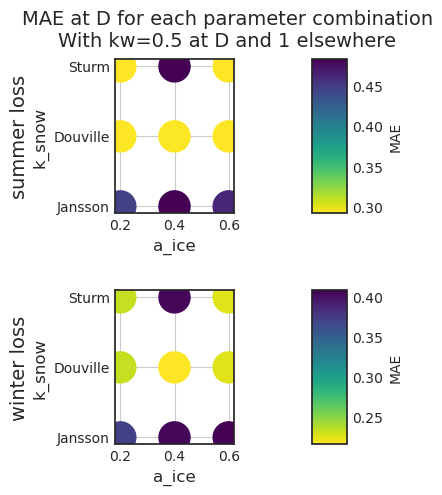

In [64]:
params_dict = {'a_ice':aa,'k_snow':kk} # 'kw':ww,
site = 'D'
idx = np.where(np.array(['AB','B','D','mean']) == site)[0][0]
fig, axes = grid_plot(params_dict,summer_result[idx],winter_result[idx])
fig.suptitle(f'MAE at {site} for each parameter combination\nWith kw=0.5 at D and 1 elsewhere',fontsize=14)
plt.savefig(f'grid_plot_{site}_nokw.png',dpi=200,bbox_inches='tight')

Douville AB
Sturm AB
Douville B
Sturm B
Douville D
Sturm D


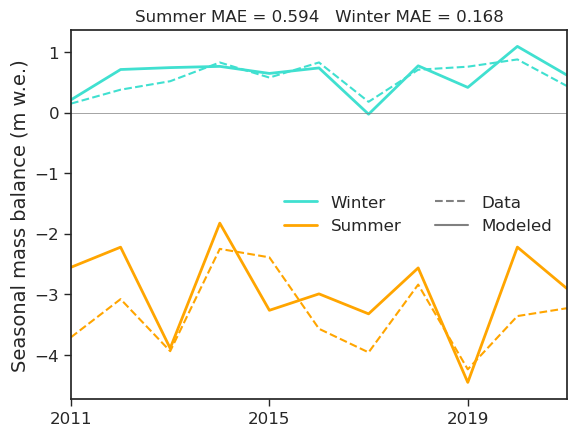

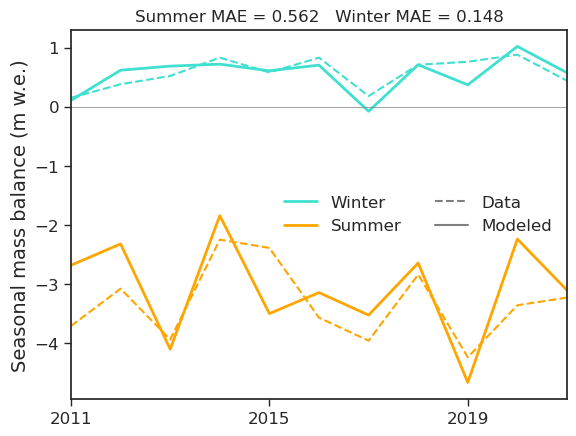

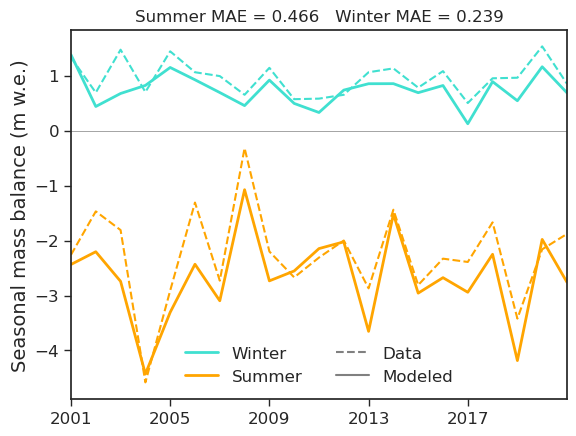

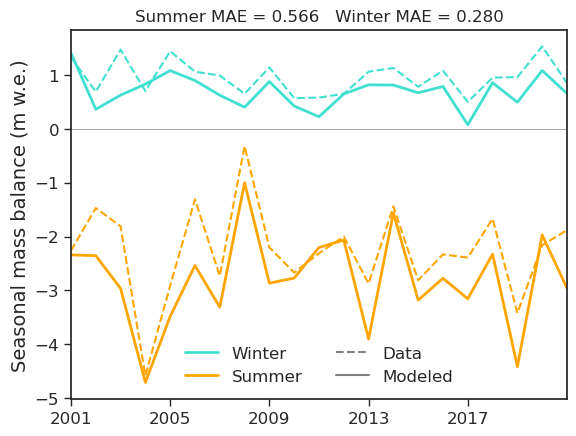

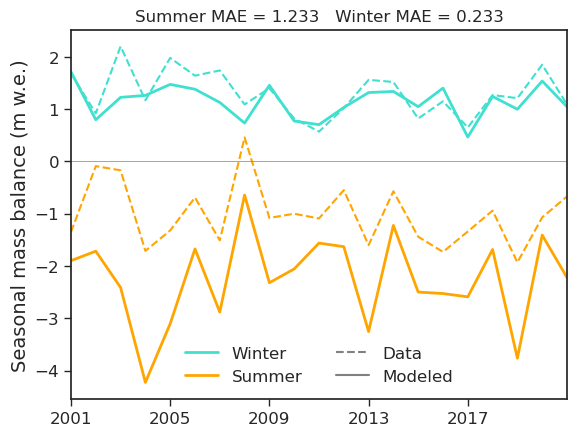

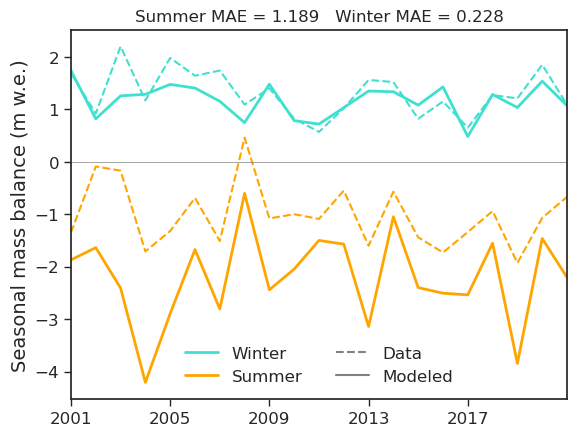

In [75]:
for site in ['AB','B','D']:
    for method in ['Douville','Sturm']:
        print(method,site)
        ds = xr.open_dataset(f'/home/claire/research/Output/calibration/09_18/ksnow{method}_aice0.5_site{site}_0.nc')
        seasonal_mass_balance(data_fp,ds,site,plot=True)

In [76]:
def plot_by(ds,time,vars,t='Monthly EB Outputs',by='month'):
    h = 1.5
    fig,axes = plt.subplots(len(vars),1,figsize=(7,h*len(vars)),sharex=True,layout='constrained')
    if len(vars) == 1:
        axes = [axes]
    
    if by == 'month':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).month)
        time_list = np.arange(1,13)
    elif by == 'hour':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).hour)
        time_list = np.arange(0,24)
    elif by == 'doy':
        ds[by] = (['time'],pd.to_datetime(ds['time'].values).day_of_year)
        time_list = np.arange(1,366)
        running_sum = 0

    if len(time) == 2:
        start = pd.to_datetime(time[0])
        end = pd.to_datetime(time[1])
        time = pd.date_range(start,end,freq='h')
    ds = ds.sel(time=time)
    c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
    for i,v in enumerate(vars):
        axis = axes[i]
        vararray = np.array(v)
        for var in vararray:
            try:
                c = next(c_iter)
            except:
                c_iter = iter([plt.cm.Dark2(i) for i in range(8)])
                c = next(c_iter)
        
            var_out = []
            for time in time_list:
                ds_sel = ds.where(ds[by] == time,drop=True)
                if 'layer' in var:
                    vardata = ds_sel.isel(layer=0)[var].to_numpy()
                else:
                    vardata = ds_sel[var].to_numpy()
                if by == 'doy':
                    nyrs = int(vardata.shape[0] / 24)
                    try:
                        vardata = np.mean(vardata.reshape(24,nyrs),axis=0)
                    except:
                        if time != 366:
                            print('Must index dates exactly 1 year - 1 day apart')
                        vardata = np.array([0])
                    out = np.mean(vardata)
                else:
                    out = np.mean(vardata)
                var_out.append(out)
            axis.plot(time_list,var_out,label=var,color=c)
            axis.legend()
            if by == 'doy':
                axis.axvline(111,color='green')
                axis.axvline(294,color='red')
    if by == 'month':
        months = pd.date_range('2024-01-01','2024-12-31',freq='MS')
        month_names = [date.month_name()[:3] for date in months]
        axis.set_xticks(np.arange(1,13),month_names)
    if by == 'doy':
        axis.set_xlabel('Day of year')
    axis.set_ylabel('Melt (mm w.e.)')
    axis.tick_params(length=5)
    fig.suptitle(t)

In [87]:
ds = xr.open_dataset('/home/claire/research/Output/EB_local/run_2023_06_20_hourly_00.nc')
ds

<xarray.Dataset>
Dimensions:      (time: 52585, bin: 3, layer: 20)
Coordinates:
  * time         (time) datetime64[ns] 1980-04-01 ... 1986-04-01
  * bin          (bin) int64 0 1 2
  * layer        (layer) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables: (12/19)
    SWin         (time, bin) float64 ...
    SWout        (time, bin) float64 ...
    LWin         (time, bin) float64 ...
    LWout        (time, bin) float64 ...
    rain         (time, bin) float64 ...
    sensible     (time, bin) float64 ...
    ...           ...
    surftemp     (time, bin) float64 ...
    snowtemp     (time, bin, layer) float64 ...
    watercont    (time, bin, layer) float64 ...
    layerheight  (time, bin, layer) float64 ...
    snowdensity  (time, bin, layer) float64 ...
    snowdepth    (time, bin) float64 ...

Must index dates exactly 1 year - 1 day apart


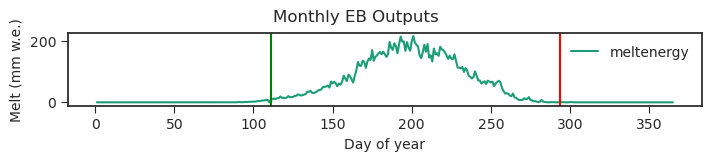

In [85]:
ds = xr.open_dataset('/home/claire/research/Output/calibration/09_18/ksnowDouville_aice0.4_siteAB_0.nc')
ds.melt.values *= 1000
plot_by(ds,[startdate,'2022-04-20'],[['meltenergy']],by='doy')

In [ ]:
ds.melt.values *= 1000
plot_by(ds,0,[startdate,enddate],[['melt']],by='doy')